# Homework 2: Linear Regression (SGEMM data)

## Homework Goal  
The goal of this homework is to do linear regression on the matrix multiplication run time. This can then be used to prediction the run time when different parameters are used in the matrix multiplication algorithm. Via this homework one can get hands-on experience and intuition about linear regression and regularization. We once again emphasize the difference between fitting and predicting. We will see that it is much more difficult to get good out-of-sample performance on a test set (predicting) than it is to get good in-sample performance on the training set (fitting).

## Overview:

In Notebook 1: __Section II: Machine Learning is difficult__, we explored linear regression in the context of a prediction problem. In this notebook, we'll formally introduce the notion of regression and see how learning and prediction can be improved by introducing regularization. We will focus mainly on simple applications of linear regression: minimizing the mean-square-error (MSE) on the training data (i.e. in-sample error) and see how well we perform on the test data (i.e. out-of-sample error). 


As we discussed in Sec. II of the review, there is a fundamental difference between minimizing the in-sample error and minimizing the out-of-sample error. The underlying reason for this is that the training data may not be representative of the full data distribution. From a Bayesian point of view, as [David MacKay](http://www.inference.org.uk/mackay/) likes to repeat: <i>We can't make predictions without making assumptions.</i> Thus, it is sensible to introduce priors that reflect the fact that we are likely to be undersampled (especially in high dimensions).

We'll consider ordinary least squares regression problem in which the "error function" is defined as the square from the deviation of our linear predictor to the true response. We will supplement this error function with a regularizer that prevents overfitting. From a Bayesian point of view, the regularization can be thought of as a prior on parameters, see Sec VI.
Minimizing the combined in-sample error + regularization terms is the same as the <b> Maximum a posteriori probability (MAP)</b> estimate in Bayesian regression (the parameters at which the posterior probability distribution is peaked). Note that in a true Bayesian approach, we should not use the mode of the posterior but the average over all possible choices of parameters weighted by their posterior probability. In practice, this is  often not done (for computational and practical reasons).



## Least squares linear regression: 

Consider data of the form $(y_i,\mathbf{x}^{(i)})$ where the index $i=1\ldots n$ runs over the number of examples in the training data and $\mathbf{x}^{(i)}$ is a $p$-dimensional feature (row) vector. For notational convenience, it is useful to define the $n \times p$ <b>design matrix</b> $X$ whose rows, $\textbf{x}^{(1)},\cdots, \textbf{x}^{(n)}$, are the examples and columns, $\mathbf{X}_{:,1},\cdots, \mathbf{X}_{:,p}$,  are the measured "features" (i.e. feature predictors). We also denote the $n$-dimensional column vector of sample $i$ as $\mathbf{y}_i$ and the $p$-dimensional column vector of regression parameters $\mathbf{w}\in\mathbb{R}^p$.

For ordinary least square regression (no regularization), we minimize the square loss cost function:

$$
\underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}} ||\textbf{Xw}-\textbf{y}||_2^2 = \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}} \,(\mathbf{Xw}-\mathbf{y})^T(\mathbf{Xw}-\mathbf{y}),
$$

or equivalently, in component form,
$$
\underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{min}}   \sum_{i=1}^n (y_i -\mathbf{w}\cdot\mathbf{x}^{(i)})^2.
$$

If rank$(\mathbf{X})=p$, namely, the feature predictors $\mathbf{X}_{:,1},\cdots \mathbf{X}_{:,p}$ are linearly independent, then there exists unique solution to this problem:

$$
\hat{\textbf{w}}= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \textbf{y}
$$

### Exercise 1: ###  
<ul>


<li> This choice of parameters correspond the maximum likehood estimate of which Likelihood function? 

<li> Derive $\hat{\textbf{w}}$ explicitly by solving the least square problem defined above.


<li> Is $\hat{\textbf{w}}$ a biased or an unbiased estimator? In other words, does it give the correct answer as the number of data points goes to infinity ($n \rightarrow \infty$). To answer this question, you may assume i.i.d. (independent, identically distributed) samples $(y_i,\textbf{x}^{(i)})$.

<li> Is $\hat{\textbf{w}}$ still well-defined when rank$(\mathbf{X})<p$? This happens when, for example, $n<p$. 

<li> Now imagine the samples are generated in the following manner: $y_i=\textbf{w}_\text{true}\cdot \textbf{x}^{(i)}+\epsilon_i$ where $\epsilon_i\sim\mathcal{N}(0,\sigma^2)$ are i.i.d. Gaussian errors. In statistics, the in-sample risk is defined as
$$
R(\hat{\textbf{w}}, \textbf{w}_\text{true})=\frac{1}{n}\mathbb{E}[(\mathbf{X}\hat{\textbf{w}}-\mathbf{X}{\textbf{w}_\text{true}})^2],
$$
where $\mathbb{E}[\cdots]$ is taken over all i.i.d pairs $(y_i,\textbf{x}^{(i)})$ and $\hat{\textbf{w}}$ is the least squares solution given above. Assuming that $\mathbf{X}$ and $\epsilon_i$ are independent, show that the risk is given by

$$
R(\hat{\textbf{w}}, \textbf{w}_\text{true}) = \sigma^2\frac{p}{n}
$$
What's the implication of this for fixed $p$ as $n \rightarrow \infty$? How about when $p,n$ scale together?

</ul>


From Exercise 1, it is clear that the uniqueness of the solution is only guaranteed when rank$(\mathbf{X})>p$. But even so we still may not want to use least squares if $p$ is moderately close to $n$, because its "risk" could be quite poor. One way to deal with this is to  <i> regularize</i>.

We will be concerned with two classes of regularizers: <b> L2-regularization</b> which is often called <b> Ridge-Regression</b> (or <b>Tikhonov regression</b>) and <b> L1-regularization</b> which goes under the name <b>LASSO</b> (and is closely related to <b>Compressed Sensing</b>).


## Ridge Regression
In Ridge-Regression, the regularization penalty is taken to be the L2-norm of the parameters
$$
E_{ridge}= \lambda ||\textbf{w}||_2^2 = \lambda \textbf{w}^T \textbf{w}=\lambda \sum_{\gamma=1}^p w_\gamma w_\gamma.
$$

Thus, the model is fit by minimizing the sum of the in-sample error and the regularization term
$$
\mathbf{w}_{ridge}(\lambda)= \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{argmin}} ||\mathbf{X}\textbf{w}-\textbf{y}||_2^2 + \lambda ||\textbf{w}||_2^2.
$$
Notice that the parameter $\lambda$ controls how much we weigh the fit and regularization term.

### Exercise 2: ###  
<ul>
<li>What choice of prior does this correspond to if we are performing a MAP estimate?
<li>Show that the solution to Ridge regression is given by $\mathbf{w}_{ridge}= (\mathbf{X}^T\mathbf{X}+\lambda I)^{-1}\mathbf{X}^T \textbf{y}$. 
<li>Express your answer in terms of the Singular Value Decomposition of $\mathbf{X}$.
</ul>

## LASSO ##

We will also be interested in the case where the penalty is the L1-norm of the parameters (sum of absolute values of parameters). This is called LASSO.
$$
E_{LASSO}= \lambda ||\mathbf{w}||_1 = \lambda \sum_{\gamma=1}^p |w_\gamma| .
$$
In this case, 
$$
\textbf{w}_{LASSO}(\lambda)= \underset{\textbf{w}\in\mathbb{R}^p}{\operatorname{argmin}} {1 \over 2n} ||\mathbf{Xw}-\mathbf{y}||_2^2 + \lambda ||\mathbf{w}||_1.
$$
Note the prefactor $1/(2n)$ in the loss function is not essential to this formulation. We have chosen this form to be consistent with the Scikit-Learn package in Python. As we discussed in the main text, LASSO tends to give sparse solution. In the following we're going to explore these ideas a little bit more.


### Exercise 3: ###  
<ul>
<li>What choice of prior does this correspond to if we are performing a MAP estimate?
<li>In this case, can you derive an analytic expression for $\mathbf{w}_{LASSO}$? Do you have any ideas about how we might be able to efficiently numerically calculate this? 
<li> Do you think LASSO and Ridge Regression will give qualitatively different answers? (Consider the limits $\lambda=0$ and $\lambda = \infty$)
</ul>

## Numerical Experiments with Ridge Regression and LASSO##

We will now perform some numerical experiments with the Diabetes Dataset trying to predict diabetes outcomes one year forward. More information about this data set can be found at <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes">https://archive.ics.uci.edu/ml/datasets/Diabetes</a>. This dataset was described in the famous <a href="http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf">Least Angle Regression</a> paper by Efron, Hastie, Johnstone, Tibshirani as follows:
<blockquote>Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of $n = 442$ diabetes patients, as well as the
response of interest, a quantitative measure of disease progression one year after baseline.</blockquote>


We start by plotting the weights for each value of $\lambda$ for Ridge Regression and LASSO. This is called a regularization path. We also compare the in-sample and out-of-sample performance between two regressions by examining the $R^2$ coefficient of determination (for detailed definition see <a href="https://en.wikipedia.org/wiki/Coefficient_of_determination">here</a>). In terms of linear regression, $R^2$ tells us how well the regression function fits the data. The best attainable fit corresponds to $R^2=1$.


In [0]:
#import data of 241600x18 data in .csv file format
import csv
from __future__ import print_function
print(__doc__)

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

#create X the data set and y the target set 
sgemm_data = np.zeros((241600,14), dtype=int)
sgemm_target = np.zeros((241600,), dtype=float)

with open('sgemm_product.csv', newline='') as csvfile:
    #get rid of the first row
    next(csvfile)
    rows = csv.reader(csvfile)
    
    i=0
    for row in rows:
        #print(row)
        
        # write in data set
        sgemm_data[i] = row[0:14]
        # write in target set
        sgemm_target[i] = 0.25*(float(row[14])+float(row[15])+float(row[16])+float(row[17]))
        
        i+=1
        
    
    print(sgemm_data[0])
    print(type(sgemm_data[0][3]))
    print(sgemm_target[3])

Automatically created module for IPython interactive environment
[16 16 16  8  8  8  8  2  1  1  0  0  0  0]
<class 'numpy.int64'>
86.6375


In [0]:
## trying session please skip it ##
import numpy as np
a = np.zeros((3,2), dtype=int)
print(a)
a[2]=[4,4]
print(a)
cite = [1,2,3,4,5]
print(cite[0:3])
new = []
new = np.append(cite[0:4], int)
print(new[3])
str = '123'
num = int(str)
print(type(num))

[[0 0]
 [0 0]
 [0 0]]
[[0 0]
 [0 0]
 [4 4]]
[1, 2, 3]
4
<class 'int'>


In [0]:
# control number of used data points
number_examples=400
X = sgemm_data[:number_examples]
y = sgemm_target[:number_examples]
print(X.shape)
print(X[2][3])
print(y.shape)

(400, 14)
8
(400,)


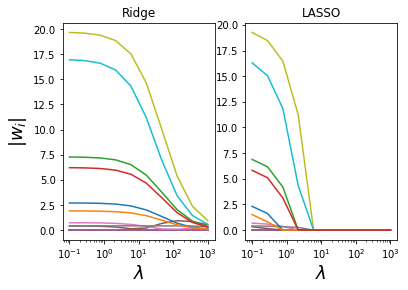

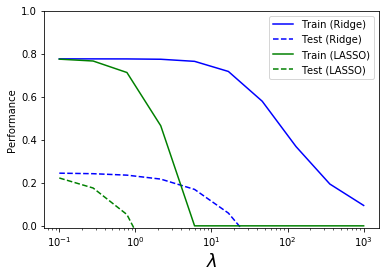

In [0]:
# Set up Lasso and Ridge Regression models
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()


# Chooose paths
alphas = np.logspace(-1, 3, 10)

# To see how well we learn, we partition the dataset into a training set with 1000 examples
# as well as a test set with 4000 examples. We record their errors respectively.

n_samples_train = 200
X_train, X_test = X[:n_samples_train], X[n_samples_train:]
y_train, y_test = y[:n_samples_train], y[n_samples_train:]
train_errors_ridge = list()
test_errors_ridge = list()

train_errors_lasso = list()
test_errors_lasso = list()



# Initialize coeffficients for ridge regression and Lasso
# alphas here are the lambda, the hyperparameter which restrict L1/ L2 norm of w within a certain range 
# also called regularization parameter

coefs_ridge = []
coefs_lasso=[]
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    
    # Use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, y_train))
    test_errors_ridge.append(ridge.score(X_test, y_test))
    
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    train_errors_lasso.append(lasso.score(X_train, y_train))
    test_errors_lasso.append(lasso.score(X_test, y_test))
    
###############################################################################
# Display results

# First see how the 10 features we learned scale as we change the regularization parameter
plt.subplot(1,2,1)
plt.semilogx(alphas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")



plt.subplot(1,2,2)
plt.semilogx(alphas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()



# Plot our performance on both the training and test data
plt.semilogx(alphas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(alphas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(alphas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(alphas, test_errors_lasso, '--g',label='Test (LASSO)')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([-0.01, 1.0])
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.show()

## Homework Observations
<ul>
<li> After doing this homework, it is obvious that __LASSO__ has better performance for both the training set and the testing set in the range of our lambda. I think this is largely due to the fact that there are some sort of __'binary encoding'__ propertiy in the parameter we try to do linear regression on. This can cause mostly zero situation in the best solution which favors LASSO. 

<li> As I increase the total number of used data (train + test) to about 5000, the test performance sometimes get a 'bump' around certain values of lambda (around $\lambda = 20$). When the total number of used data come to about 50000, the test performance  almost disappear which is very weird.
</ul>

Automatically created module for IPython interactive environment
(200, 10)
(200,)


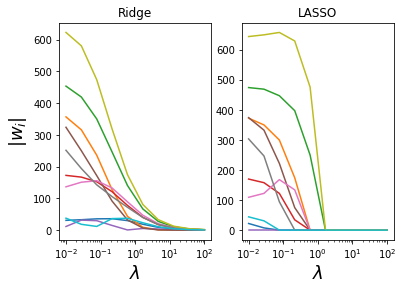

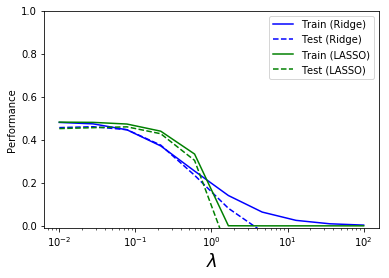

In [0]:
from __future__ import print_function
print(__doc__)

%matplotlib inline

# This code is modified from plot_cv_diabetes.py in the skit-learn documentation
# and plot_ridge_path.py


import numpy as np
import matplotlib.pyplot as plt
#import seaborn

from sklearn import datasets, linear_model

# Load Training Data set with 200 examples

number_examples=200
diabetes = datasets.load_diabetes()
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]
print(X.shape)
print(y.shape)


# Set up Lasso and Ridge Regression models
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()


# Chooose paths
alphas = np.logspace(-2, 2, 10)

# To see how well we learn, we partition the dataset into a training set with 150 
# as well as a test set with 50 examples. We record their errors respectively.

n_samples = 150
n_samples_train = 100
X_train, X_test = X[:n_samples_train], X[n_samples_train:]
y_train, y_test = y[:n_samples_train], y[n_samples_train:]
train_errors_ridge = list()
test_errors_ridge = list()

train_errors_lasso = list()
test_errors_lasso = list()



# Initialize coeffficients for ridge regression and Lasso

coefs_ridge = []
coefs_lasso=[]
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)
    
    # Use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, y_train))
    test_errors_ridge.append(ridge.score(X_test, y_test))
    
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    train_errors_lasso.append(lasso.score(X_train, y_train))
    test_errors_lasso.append(lasso.score(X_test, y_test))
    
###############################################################################
# Display results

# First see how the 10 features we learned scale as we change the regularization parameter
plt.subplot(1,2,1)
plt.semilogx(alphas, np.abs(coefs_ridge))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')
#plt.savefig("Ridge_sparsity_scale.pdf.pdf")



plt.subplot(1,2,2)
plt.semilogx(alphas, np.abs(coefs_lasso))
axes = plt.gca()
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel(r'$\lambda$',fontsize=18)
#plt.ylabel('$|\mathbf{w}|$',fontsize=18)
plt.title('LASSO')
#plt.savefig("LASSO_sparsity_scale.pdf")
plt.show()



# Plot our performance on both the training and test data
plt.semilogx(alphas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(alphas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(alphas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(alphas, test_errors_lasso, '--g',label='Test (LASSO)')
#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([-0.01, 1.0])
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('Performance')
#plt.savefig("Ridge_LASSO_sparsity_performance.pdf")
plt.show()





### Exercise 4: ###  
<ul>
<li>What do the points $\lambda=0$ and $\lambda=10^5$ correspond to? Is it strange that the weights are not monotonic in $\alpha$? Why do you think this might be?
<li>Make a similar regularization plot for LASSO? 
<li> What is the qualitative difference between the LASSO path and Ridge Path? Does this agree with your earlier predictions? Can you make some qualitative argument to rationalize this difference?
<li>How do your answers change when you vary the number of examples and training set size?
</ul>

## A brief note about convexity##

In Sec. VI of the review, we briefly discussed convexity. Here's a quick refresher: Recall that a set $C\subseteq\mathbb{R}^n$ is called <i> convex </i> if any $x,y\in C$ and $t\in [0,1]$, 
$$
tx+(1-t)x \in C.
$$
In other words, every line segments joining $x,y$ lies entirely in $C$. 

A function $f:\mathbb{R}^n\rightarrow \mathbb{R}$ is called <i> convex </i> if its domain dom$(f)$ is a convex set and for any $x,y\in$dom$(f)$ and $t\in [0,1]$, 

$$
f(tx+(1-t)y)\le tf(x)+(1-t)f(y).
$$
In other words, the function lies below the line segment joining $f(x)$ and $f(y)$. This function $f$ is called <b> strictly convex </b> if this inequality holds strictly for $x\neq y$ and $t\in(0,1)$. 

Why is convexity important?  <b> For convex functions, any local minimizer is a global minimizer</b>. Algorithmically, this means that in the minimization (optimization) procedure, as long as we're "going down the hill" and agree to stop when we can't go any further, then we've hit the global minimum. In addition to this, there's a menagerie of beautiful theory regarding convex duality and optimality, which gives us a way of understanding the solutions even before solving the problem itself. We refer interested readers to  <a href="http://web.stanford.edu/~boyd/cvxbook/">Boyd and Vandenberghe book on Convex Optimization</a>.


Coming back to our regularization examples, a simple inspection reveals that both LASSO and Ridge regression are convex in $w$. What's more, Ridge is actually a <i> strictly convex </i> problem (assuming $\lambda>0$) due to presence of L2 penality. In fact, this is always true regardless of $X$ and so the ridge regression solution you worked out (presumably) in Exercise 2 is always well-defined.

In contrast, LASSO is not always strictly convex and hence by convexity
theory, it need not have a unique solution. The LASSO solution is unique under general conditions, for example, when $X$ has columns in <i> general position </i> (see <a href="https://arxiv.org/abs/1206.0313"> Tibshirani 2013</a>). To mitigate this, one can define a modified problem called the <a href="https://web.stanford.edu/~hastie/Papers/B67.2%20(2005)%20301-320%20Zou%20&%20Hastie.pdf">elastic net</a> such that the function we want to minimize is always strictly convex:

$$
\underset{\mathbf{w}\in\mathbb{R}^p}{\operatorname{min}} ||\mathbf{Xw}-\mathbf{y}||_2^2 + \lambda ||\mathbf{w}||_1 + \delta||\mathbf{w}||_2^2,
$$
where $\lambda,\delta\ge 0$ are regularization parameters. Now aside from uniqueness of the solution, the elastic net combines some of the desirable properties (e.g. prediction) of ridge regression with the sparsity properties of the LASSO. In the following exercise, you're going to explore a little bit about elastic net.

### Exercise 4: ###  
<ul>
<li> Play with the parameters $\lambda$ and $\delta$, when would you expect sparse solutions?

<li> Plot the regularization path of elastic net. How does it depend on $\lambda$ and $\delta$?

<li> Derive the analytic solution of this elastic net problem. Check your answer by looking at two limiting cases ($\lambda\rightarrow 0$ and $\delta\rightarrow 0$). Does this agree with what you found previously?

</ul>

### End-of-notebook questions ###  
<ul>

<li> Can you explain the difference between in-sample and out-of-sample performance? Is out-of-sample error usually larger than in-sample error? Does this depend on regularization? Recall in Exercise 1, we defined the in-sample risk as 

$$
R_{in}(\hat{\textbf{w}}, \textbf{w}_\text{true})=\frac{1}{n}\mathbb{E}[(\mathbf{X}\hat{\textbf{w}}-\mathbf{X}{\textbf{w}_\text{true}})^2],
$$ 
where $\hat{\textbf{w}}= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \textbf{y}$ is the least square solution and $\textbf{w}_\text{true}$ is the true parameter vector used to generate all samples. Following the same notation and assumption, now imagine if we're given a new data point $\textbf{x}_0$ independently drawn from the predictor distribution $\mathcal{P}$. We can define the out-of-sample risk as 
$$
R_{out} =\mathbb{E}_{\textbf{x}^{(0)}\sim\mathcal{P}}\mathbb{E}_{(y_i,\textbf{x}_i)}[(\hat{\textbf{w}}\cdot \textbf{x}_0 -\textbf{w}_\text{true}\cdot \textbf{x}_0)^2],
$$
with the expectation value taken not only over the training samples $(y_i,\textbf{x}_i)$ but also over the predictor distribution $\mathcal{P}$ that generates the unseen sample $\textbf{x}^{(0)}$. One can actually show that $R_{out}\ge R_{in}$ under mild assumptions. This makes sense intuitively since it's usually harder to make prediction on unseen samples than to fit the samples given. You can numerically verify this by assuming a predictor distribution, say, $\mathcal{N}(0,\Sigma)$.
</ul>